## 3 - Conducting the experiment using a VPN

Rather than using EC2 to simulate requests from different locations in Singapore, we can use a VPN instead to avoid the bias that was discussed in the previous run. However, one disadvantage with a VPN service would be that we will not know if the origin of the requests will be spread out or close together. 

This run can be conducted in the same manner through the local machine, or through an EC2 instance as long as a network VPN is applied. NordVPN was used and 9000 requests were made proxied through three different NordVPN servers in Singapore.

## OLS Regression Specification

$$ log(T_i) = \beta_0 + \beta_1\text{Nginx}_i + \beta_2\text{Cloudfront}_i + \beta_3\text{vpn-2}_i + \beta_4\text{vpn-3}_i + \epsilon_i $$

Where:
* $ T_i = $ Dependent variable. The response time of the $i$th HTTP GET request for the payload file
* $ \text{Nginx}_i = $ Dummy variable of the $i$the request if the file source is from the Nginx server
* $ \text{Cloudfront}_i = $ Dummy variable of the $i$the request if the file source is from the CDN
* $ \text{vpn-2}_i = $ Dummy variable of the $i$the request if the request is proxied from the second Singapore vpn server
* $ \text{vpn-3}_i = $ Dummy variable of the $i$the request if the request is proxied from the third Singapore vpn


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf

In [7]:
df_a = pd.read_csv("./data/sg-vpn-1-data.csv")
df_b = pd.read_csv("./data/sg-vpn-2-data.csv")
df_c = pd.read_csv("./data/sg-vpn-3-data.csv")
df = df_a.append(df_b).append(df_c)

In [8]:
df['resp_time'] = df['resp_time'] * 1000 # Convert to milliseconds
df['ln_resp_time'] = np.log(df['resp_time']) # Log response times

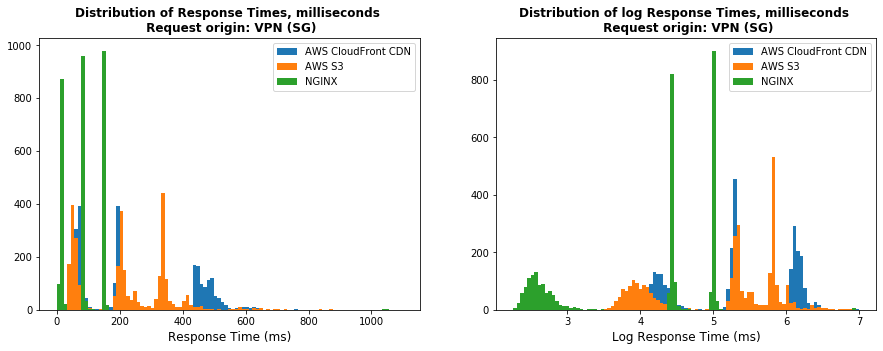

Mean response times (ms): 255.30652666666668 (CloudFront), 218.870238 (S3), 84.998068 (NGINX) 
Variance: 36033.54 (CloudFront), 21997.82 (S3), 5870.15 (NGINX) 
N=9000


In [9]:
cdn, ln_cdn = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='CLOUDFRONT'].values)
s3, ln_s3 = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='S3'].values)
nginx, ln_nginx = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='NGINX'].values)

bins = np.linspace(0, df['resp_time'].quantile(0.999), 100) # Less outliers
ln_bins = np.linspace(df['ln_resp_time'].min(), df['ln_resp_time'].quantile(0.999), 100)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.hist(cdn, bins=bins, label='AWS CloudFront CDN')
ax1.hist(s3, bins=bins, label='AWS S3')
ax1.hist(nginx, bins=bins, label='NGINX')
ax1.set_title('Distribution of Response Times, milliseconds \n Request origin: VPN (SG)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_xlabel("Response Time (ms)", fontsize=12)

ax2.hist(ln_cdn, bins=ln_bins, label='AWS CloudFront CDN')
ax2.hist(ln_s3, bins=ln_bins, label='AWS S3')
ax2.hist(ln_nginx, bins=ln_bins, label='NGINX')
ax2.set_title('Distribution of log Response Times, milliseconds \n Request origin: VPN (SG)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_xlabel("Log Response Time (ms)", fontsize=12)

plt.savefig('./static/local-hist.png')
plt.show()

print(f"Mean response times (ms): {np.mean(cdn)} (CloudFront), {np.mean(s3)} (S3), {np.mean(nginx)} (NGINX) ")
print(f"Variance: {np.var(cdn):.2f} (CloudFront), {np.var(s3):.2f} (S3), {np.var(nginx):.2f} (NGINX) ")
print(f"N={df.shape[0]}")

In [10]:
# Get server dummies - s3 as base
server_dummies = pd.get_dummies(df['server']).drop('S3', axis=1)

# Get vpn dummies - sg-vpn-1 as base
vpn_dummies = pd.get_dummies(df['origin'], drop_first=True)

In [11]:
df = pd.concat([df, server_dummies], axis=1)
df = pd.concat([df, vpn_dummies], axis=1)

In [13]:
df.rename(columns={
    "sg-vpn-1" : "sg_vpn_1",
    "sg-vpn-2" : "sg_vpn_2",
    "sg-vpn-3" : "sg_vpn_3",
}, inplace=True)

In [14]:
results = smf.ols("ln_resp_time ~ NGINX + CLOUDFRONT + sg_vpn_2 + sg_vpn_3 ", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_resp_time   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                 3.910e+04
Date:                Tue, 15 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:46:53   Log-Likelihood:                -76.087
No. Observations:                9000   AIC:                             162.2
Df Residuals:                    8995   BIC:                             197.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9444      0.006    685.587      0.0

## Discussion

Using a VPN to proxy requests from different servers in Singapore, our OLS regression estimates now seem to support our initial results, that requests from CloudFront CDN are in fact slower than requests from S3, within the Singapore region. For this run, requests to the CDN are associated with a $100(e^{0.1482}-1)=15.9$ percent increase in response times while requests to the Nginx server are associated with $100(e^{-1.0723}-1)=-65.8$ percent decrease in response times. These estimates are statistically significant at the $\alpha=0.01$ level of significance. 

## Conclusion

It is common practice to deploy a CDN to speed up the delivery of static content, and in most cases, the CDN does the job well by caching the content on geographically distributed servers. Users will retrieve content through servers located nearest to them, thereby reducing response times. However, for an application serving a local region, the benefits of using a CDN may be diminished, especially in a geographically tiny region such as Singapore.

This analysis has shown statistically that serving static content in the Singapore region through a CDN (CloudFront) can in fact be slower than through a basic cloud storage service (AWS S3). In addition, our analysis also suggests that a Nginx static file server outperforms both the CDN and the cloud storage service in this area. 

However, a few caveats are in order. The response times are recorded via network requests through a local machine, vpn, and ec2 instances. These timings may not be representative of the typical user experience as the variation in origin locations of the experimental requests are quite limited. 

These comparisons are also conducted solely on AWS infrastructure. Using other cloud storage / CDN service providers may yield different results. 

Lastly, the performance of the Nginx server is likely biased downwards (faster) as the requests to the file server are HTTP based, as compared to HTTPS on S3 and CloudFront. Enabling HTTPS on the Nginx file server would be a fairer comparison against the other methods as the time taken for the SSL/TLS handshake is not insignificant at the millisecond scale. 